**Importing libraries**

In [ ]:
import numpy as np
import pandas as pd 
import os
import torch 
import sys
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import albumentations as A
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF
from xml.etree import ElementTree as et # To read .xlm files since our data contains .xml files.
import warnings
warnings.filterwarnings('ignore')# To ignore warnings in the code

**Importing data from Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


**Unzip the data**

In [ ]:
!unzip '/content/gdrive/MyDrive/CV A3/Fruits_Data_Set.zip'

Archive:  /content/gdrive/MyDrive/CV A3/Fruits_Data_Set.zip
  inflating: test_zip/test/apple_77.jpg  
  inflating: test_zip/test/apple_77.xml  
  inflating: test_zip/test/apple_78.jpg  
  inflating: test_zip/test/apple_78.xml  
  inflating: test_zip/test/apple_79.jpg  
  inflating: test_zip/test/apple_79.xml  
  inflating: test_zip/test/apple_80.jpg  
  inflating: test_zip/test/apple_80.xml  
  inflating: test_zip/test/apple_81.jpg  
  inflating: test_zip/test/apple_81.xml  
  inflating: test_zip/test/apple_82.jpg  
  inflating: test_zip/test/apple_82.xml  
  inflating: test_zip/test/apple_83.jpg  
  inflating: test_zip/test/apple_83.xml  
  inflating: test_zip/test/apple_84.jpg  
  inflating: test_zip/test/apple_84.xml  
  inflating: test_zip/test/apple_85.jpg  
  inflating: test_zip/test/apple_85.xml  
  inflating: test_zip/test/apple_86.jpg  
  inflating: test_zip/test/apple_86.xml  
  inflating: test_zip/test/apple_87.jpg  
  inflating: test_zip/test/apple_87.xml  
  inflating: tes

**Training and test directories**

In [ ]:
training= '/content/train_zip/train'
test = '/content/test_zip/test'

**Defining function for reading images including .xml files and converting to tensors**

In [ ]:
class FruitImageDataset(torch.utils.data.Dataset):
    
    def __init__(self, files_dir, width, height, transforms=None):
        self.files_dir = files_dir
        self.width = width
        self.height = height
        self.transforms = transforms 
        # Defining classes, a blank class for background is given
        self.classes_ = [ _, 'apple', 'orange', 'banana']  
        
        self.images = [img for img in sorted(os.listdir(files_dir)) if img[-4:]=='.jpg']
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.files_dir, img_name)
        
        # Reading the image
        img = cv2.imread(img_path)
        
        # Width and height of image
        wt = img.shape[1]
        ht = img.shape[0]
        
        # Converting image to RGB channel and normalizing the image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img = cv2.resize(img, (self.width, self.height), cv2.INTER_AREA)
        img /= 255.0
        
        annot_name = img_name[:-4] + '.xml'
        annot_path = os.path.join(self.files_dir, annot_name)
        
        # Boxes to store the coordinate points of the bounding boxes
        boxes, labels = [], []
        
        tree = et.parse(annot_path)
        root = tree.getroot()
        
        # Box coordinates are extracted from the XML files for the given image size
        for member in root.findall('object'):
            labels.append(self.classes_.index(member.find('name').text))
            
            xmin = float(member.find('bndbox').find('xmin').text)
            xmax = float(member.find('bndbox').find('xmax').text)
            ymin = float(member.find('bndbox').find('ymin').text)
            ymax = float(member.find('bndbox').find('ymax').text)
            
            x_min = (xmin/wt)*self.width
            x_max = (xmax/wt)*self.width
            y_min = (ymin/ht)*self.height
            y_max = (ymax/ht)*self.height
            
            boxes.append([x_min, y_min, x_max, y_max])
            
        # Conversion to Tensors   
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Calculating area of the boxes
        area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])  
        
        iscrowd = torch.zeros((boxes.shape[0], ), dtype=torch.int64)
        
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        image_id = torch.tensor([idx])
        
        target = {'boxes': boxes, 'area': area, 'labels': labels, 
                'iscrowd': iscrowd, 'image_id':image_id}
        
        if self.transforms:
            sample = self.transforms(image = img,
                                    bboxes = target['boxes'],
                                    labels = labels)
            
            img = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
        return img, target

In [ ]:
dataset = FruitImageDataset(training, 224, 224)
print('length of dataset = ', len(dataset), '\n') # printing number of training images and resizing

length of dataset =  240 



In [ ]:
img, target = dataset[18]
print(img.shape, '\n',target)

(224, 224, 3) 
 {'boxes': tensor([[ 80.0000,  53.9087, 193.2800, 205.4108]]), 'area': tensor([17162.1543]), 'labels': tensor([1]), 'iscrowd': tensor([0]), 'image_id': tensor([18])}


**Visualizing images with  bounding boxes**

In [ ]:
def plot_img_bbox(img, target):
    
    # ploting  the image and bounding boxes
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    # Bounding boxes are defined as follows: x-min y-min width height
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = mpatches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Drawing the bounding box on top of the image
        a.add_patch(rect)
    plt.show()

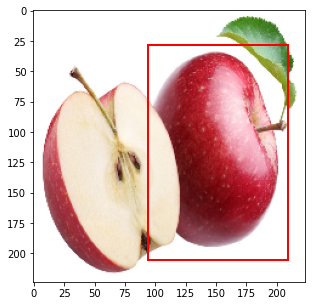

In [ ]:
img, target = dataset[25]
plot_img_bbox(img, target)

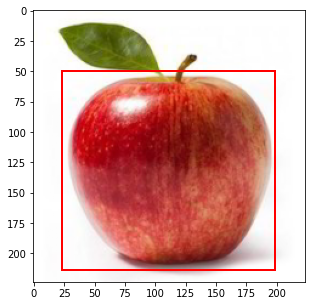

In [ ]:
img, target = dataset[68]
plot_img_bbox(img, target)

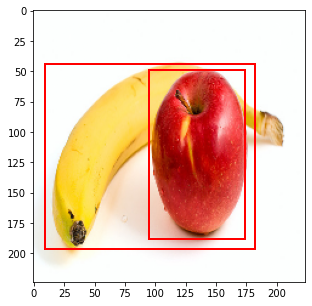

In [ ]:
img, target = dataset[129]
plot_img_bbox(img, target)

**Clonning github repository for transfer learning**

In [ ]:
!pip install pycocotools --quiet
!git clone https://github.com/pytorch/vision.git
!git checkout v0.3.0

!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

Cloning into 'vision'...
remote: Enumerating objects: 271097, done.
remote: Counting objects: 100% (10298/10298), done.
remote: Compressing objects: 100% (540/540), done.
remote: Total 271097 (delta 9804), reused 10210 (delta 9738), pack-reused 260799
Receiving objects: 100% (271097/271097), 542.69 MiB | 39.64 MiB/s, done.
Resolving deltas: 100% (247549/247549), done.
fatal: not a git repository (or any of the parent directories): .git


**Loading pre-trained model**

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import *
from engine import train_one_epoch, evaluate
def get_model(num_classes):
    
    # Loading the  Faster RCNN pre-trained model
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT,pretrained=True)
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
        return model

**Applying data augmentation**

In [ ]:
from albumentations.pytorch import ToTensorV2
def get_transform(train=True):
    if train:
        return A.Compose([
            A.HorizontalFlip(0.5),
            ToTensorV2(p=0.1),     # ToTensorV2 will convert image to PyTorch tensor without dividing by 255
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))
    else:
        return A.Compose([
            ToTensorV2(p=0.1),     # ToTensorV2 will conver image to PyTorch tensor without dividing by 255
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

In [ ]:
import utils

In [ ]:
test_split = 0.2

# Loading data with all transformations
training_data = FruitImageDataset(training, 480, 480, transforms=get_transform(train=True))
test_data = FruitImageDataset(training, 480, 480, transforms=get_transform(train=False))

torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

# Train test split
tsize = int(len(dataset) * test_split) # Getting the splitting index
training_data = torch.utils.data.Subset(training_data, indices[:-tsize])
test_data = torch.utils.data.Subset(test_data, indices[-tsize:])

# Defining dataloaders
dataloader_train = torch.utils.data.DataLoader(training_data, batch_size=8, shuffle=True,
                                              num_workers=4,  collate_fn=utils.collate_fn)  # Imported form helper library
dataloader_test = torch.utils.data.DataLoader(test_data, batch_size=8, shuffle=True,
                                              num_workers=4,  collate_fn=utils.collate_fn)

**Start training the model**

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 4 # 3 classes are for fruits and 1 is for background
num_epochs = 10

def start_training(modelName, num_epochs, num_classes):
    model = get_model(num_classes)
    model.to(device)
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.005)
    
    # Learning rate decreases by 10 after every 5 epochs
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    
    for epoch in range(num_epochs):
        train_one_epoch(model, optimizer, dataloader_train, device, epoch, print_freq=5)
        lr_scheduler.step()
        evaluate(model, dataloader_test, device=device)
    return model

In [ ]:
fast_rcnn = start_training('FasterRcnn', num_epochs, num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

Epoch: [0]  [ 0/24]  eta: 0:04:51  lr: 0.000222  loss: 1.5222 (1.5222)  loss_classifier: 1.2767 (1.2767)  loss_box_reg: 0.2360 (0.2360)  loss_objectness: 0.0051 (0.0051)  loss_rpn_box_reg: 0.0042 (0.0042)  time: 12.1363  data: 1.6488  max mem: 7173
Epoch: [0]  [ 5/24]  eta: 0:01:01  lr: 0.001308  loss: 1.0677 (1.1700)  loss_classifier: 0.8392 (0.9028)  loss_box_reg: 0.2360 (0.2574)  loss_objectness: 0.0031 (0.0046)  loss_rpn_box_reg: 0.0043 (0.0052)  time: 3.2485  data: 0.2871  max mem: 7436
Epoch: [0]  [10/24]  eta: 0:00:34  lr: 0.002394  loss: 0.9371 (0.9696)  loss_classifier: 0.5715 (0.6843)  loss_box_reg: 0.2777 (0.2758)  loss_objectness: 0.0031 (0.0044)  loss_rpn_box_reg: 0.0044 (0.0052)  time: 2.4525  data: 0.1698  max mem: 7436
Epoch: [0]  [15/24]  eta: 0:00:19  lr: 0.003480  loss: 0.8017 (0.8863)  loss_classifier: 0.4971 (0.5913)  loss_box_reg: 0.2777 (0.2843)  loss_objectness: 0.0040 (0.0049)  loss_rpn_box_reg: 0.0045 (0.0058)  time: 2.1587  data: 0.1254  max mem: 7436
Epoch: 

**Applying non-maximal suppression**

In [ ]:
from torchvision import transforms
def apply_nms(prediction, threshold):
    # torchvision returns the indices of the boxes to keep
    keep = torchvision.ops.nms(prediction['boxes'], prediction['scores'], threshold)
    
    final_prediction = prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

# Defining function to convert torch tensor to a PIL Image
def tensorToPIL(img):
    return transforms.ToPILImage()(img).convert('RGB')

**Testing the model**

In [ ]:
img, target = test_data[33]

# put the model in evaluation mode
fast_rcnn.eval()
with torch.no_grad():
    prediction = fast_rcnn([img.to(device)])[0]
    
print('predicted number of boxes are: ', len(prediction['labels']))
print('real number of boxes are: ', len(target['labels']))

predicted #boxes:  10
real #boxes:  3


In [ ]:
nms_preds = apply_nms(prediction, threshold=0.2)

**converting numpy to cuda tensors**

In [ ]:
prediction["boxes"] = prediction["boxes"].cpu()
prediction["labels"] = prediction["labels"].cpu()

EXPECTED OUTPUT


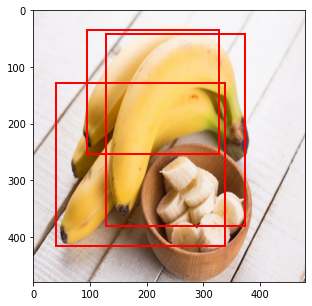

In [ ]:
print('EXPECTED MODEL OUTPUT')
plot_img_bbox(tensorToPIL(img), target)

MODEL OUTPUT


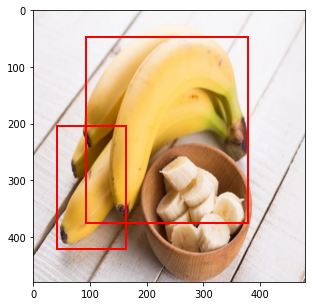

In [ ]:
print('ACTUAL MODEL OUTPUT')
plot_img_bbox(tensorToPIL(img), prediction)

NMS APPLIED MODEL OUTPUT


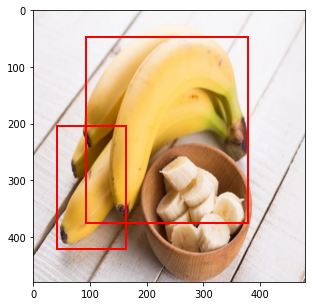

In [ ]:
print('MODEL OUTPUT AFTER NMS')
plot_img_bbox(tensorToPIL(img), nms_preds)